# EEG Inverse Problem - Julia Native Implementation

Этот ноутбук демонстрирует стабильный подход к решению обратной задачи ЭЭГ:
- **Данные**: Генерируются через Python модуль `eeg_data_generator` (используя PythonCall)
- **Обучение**: Выполняется нативным Julia кодом (InverseNpde модуль)

## Преимущества подхода:
1. **Стабильность**: Julia kernel не падает (нет JuliaCall/PyJulia)
2. **Производительность**: Нативный Julia код для тяжёлых вычислений
3. **Совместимость**: Переиспользование Python кода для генерации данных

## 1. Настройка окружения

In [1]:
# ============================================================
# ВАЖНО: Настраиваем Python из виртуального окружения .venv
# Это должно быть выполнено до любого using PythonCall!
# ============================================================
venv_python = joinpath(@__DIR__, "..", ".venv", "bin", "python")
if isfile(venv_python)
    ENV["JULIA_PYTHONCALL_EXE"] = venv_python
    println("✓ Python из .venv: ", venv_python)
else
    error("Виртуальное окружение .venv не найдено! Запустите: python -m venv .venv && . .venv/bin/activate && pip install -e .")
end

✓ Python из .venv: /home/sasha/inverse-npde/examples/../.venv/bin/python


In [2]:
# Активируем проект и устанавливаем зависимости
using Pkg
Pkg.activate("..")

# Проверяем, что PythonCall установлен
if !haskey(Pkg.project().dependencies, "PythonCall")
    Pkg.add("PythonCall")
end

Pkg.instantiate()
println("✓ Окружение готово")

  Activating project at `~/inverse-npde`


✓ Окружение готово


## 2. Загрузка Julia модулей

In [3]:
# Загружаем главный модуль InverseNpde
# Примечание: При первом запуске может потребоваться время на компиляцию
using InverseNpde

println("✓ InverseNpde загружен")
println("Доступные устройства: ", get_available_devices())

📦 InverseProblem модуль загружен
🖥️  Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)
✓ InverseNpde загружен
Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)


## 3. Настройка PythonCall и генерация данных

In [4]:
# Загружаем PythonCall для доступа к Python модулям
# Примечание: ENV["JULIA_PYTHONCALL_EXE"] уже установлена в первой ячейке
using PythonCall

# Проверяем, что используется правильный Python
py_python = pyimport("sys")
println("Python executable: ", py_python.executable)

# Добавляем путь к Python пакету inverse_npde
py_python.path.insert(0, joinpath(@__DIR__, "..", "src"))

# Импортируем Python модуль генерации данных
eeg_gen = pyimport("inverse_npde.eeg_data_generator")

println("✓ Python модуль загружен через PythonCall")

Python executable: /home/sasha/inverse-npde/.venv/bin/python
✓ Python модуль загружен через PythonCall


In [5]:
# Создаём генератор данных EEG
# Параметры можно менять для разных экспериментов
num_sensors = 32        # Количество датчиков
sampling_rate = 50.0    # Частота дискретизации (Гц)
duration = 1.0          # Длительность (секунды)
noise_level = 0.005     # Уровень шума
head_type = "adult"     # Тип головы

# Создаём Python объект генератора
py_generator = eeg_gen.EEGDataGenerator(
    num_sensors, sampling_rate, duration, noise_level, head_type
)

# Добавляем источники сигнала по умолчанию
py_generator.create_default_sources()

println("✓ Генератор создан: $num_sensors датчиков, $(sampling_rate)Гц × $(duration)сек")

✓ Генератор создан: 32 датчиков, 50.0Гц × 1.0сек


### 3.1 Визуализация датчиков (из Python)

In [6]:
# Получаем позиции датчиков из Python
# Используем pyconvert для конвертации Python объектов в Julia
py_sensor_positions = py_generator.sensor_gen.get_sensor_positions()
sensor_positions = Matrix{Float64}(undef, num_sensors, 3)
for i in 1:num_sensors
    sensor_positions[i, 1] = pyconvert(Float64, py_sensor_positions[i-1][0])  # x
    sensor_positions[i, 2] = pyconvert(Float64, py_sensor_positions[i-1][1])  # y
    sensor_positions[i, 3] = pyconvert(Float64, py_sensor_positions[i-1][2])  # z
end

# Получаем размеры головы
py_head_dims = py_generator.sensor_gen.get_head_dimensions()
rx = pyconvert(Float64, py_head_dims["rx"])
ry = pyconvert(Float64, py_head_dims["ry"])
rz = pyconvert(Float64, py_head_dims["rz"])

println("✓ Позиции датчиков получены: $num_sensors точек")
println("  Размеры головы: X=$rx, Y=$ry, Z=$rz")

✓ Позиции датчиков получены: 32 точек
  Размеры головы: X=8.5, Y=9.5, Z=10.5


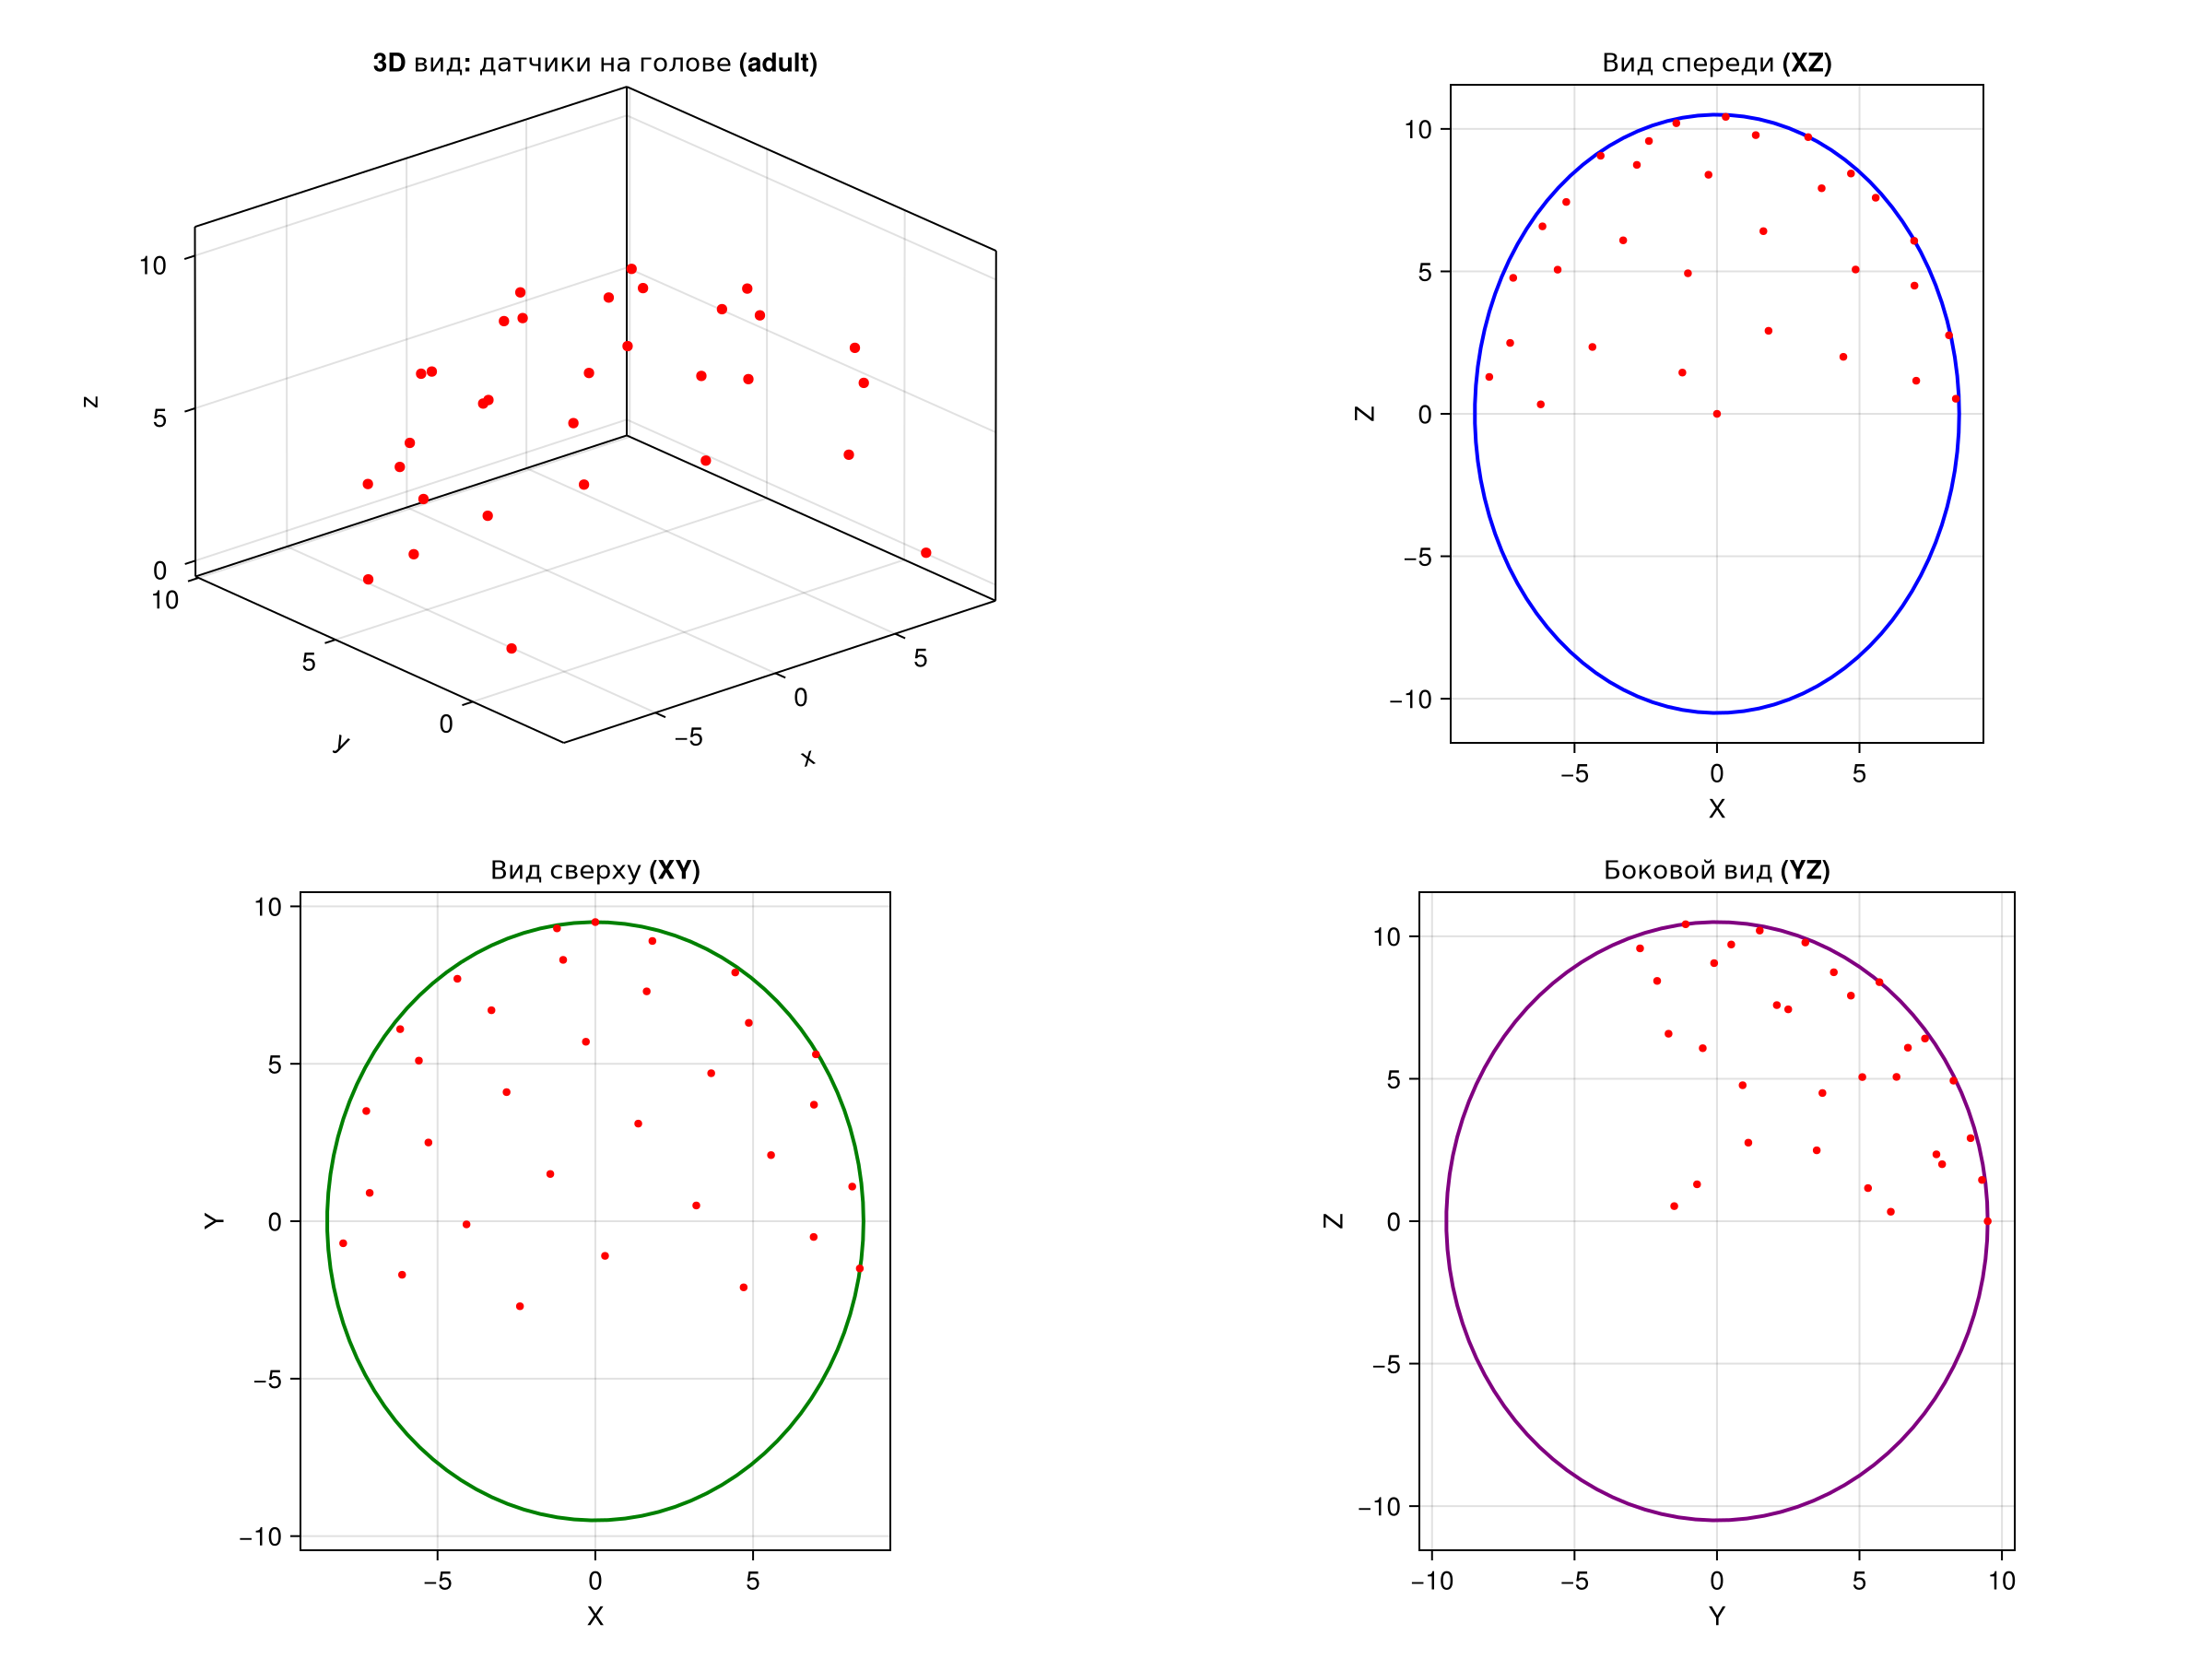

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Визуализация датчиков отображена


In [7]:
using CairoMakie

# Визуализация расположения датчиков (аналогично Python)
# создаём угол сетки
theta = LinRange(0, 2π, 100)

fig = Figure(resolution=(1200, 900))

# 3D вид
ax1 = Axis3(fig[1, 1], title="3D вид: датчики на голове ($head_type)")
scatter!(ax1, sensor_positions[:, 1], sensor_positions[:, 2], sensor_positions[:, 3];
         markersize=8, color=:red)

# Вид спереди (XZ)
ax2 = Axis(fig[1, 2], title="Вид спереди (XZ)", xlabel="X", ylabel="Z", aspect=DataAspect())
x_contour = rx .* cos.(theta)
z_contour = rz .* sin.(theta)
lines!(ax2, x_contour, z_contour; color=:blue, linewidth=2)
scatter!(ax2, sensor_positions[:, 1], sensor_positions[:, 3];
         markersize=6, color=:red)

# Вид сверху (XY)
ax3 = Axis(fig[2, 1], title="Вид сверху (XY)", xlabel="X", ylabel="Y", aspect=DataAspect())
x_top = rx .* cos.(theta)
y_top = ry .* sin.(theta)
lines!(ax3, x_top, y_top; color=:green, linewidth=2)
scatter!(ax3, sensor_positions[:, 1], sensor_positions[:, 2];
         markersize=6, color=:red)

# Боковой вид (YZ)
ax4 = Axis(fig[2, 2], title="Боковой вид (YZ)", xlabel="Y", ylabel="Z", aspect=DataAspect())
y_side = ry .* cos.(theta)
z_side = rz .* sin.(theta)
lines!(ax4, y_side, z_side; color=:purple, linewidth=2)
scatter!(ax4, sensor_positions[:, 2], sensor_positions[:, 3];
         markersize=6, color=:red)

# Отобразить фигуру
display(fig)
println("✓ Визуализация датчиков отображена")


In [8]:
# Генерируем измеренные точки
py_measured_points = py_generator.generate_measured_points()

println("✓ Сгенерировано точек: ", length(py_measured_points))

✓ Сгенерировано точек: 1600


In [9]:
# Извлекаем measured_phi из py_measured_points для визуализации
# Структура py_measured_points: [x, y, z, t, measurement] для каждой точки
# Данные организованы: для каждого t идут все датчики подряд

num_time_steps = Integer(sampling_rate * duration) + 1
measured_phi = zeros(num_sensors, num_time_steps)

# Заполняем матрицу measured_phi[sensor, time_step]
for (idx, point) in enumerate(py_measured_points)
    sensor_idx = (idx % num_sensors) + 1  # Julia индексация с 1
    time_idx = div(idx, num_sensors) + 1
    measured_phi[sensor_idx, time_idx] = pyconvert(Float64, point[4])  # measurement = point[4] (0-indexed в Python)
end

println("Матрица measured_phi извлечена: ", size(measured_phi))

Матрица measured_phi извлечена: (32, 51)


### 3.2 Визуализация временных рядов (измеренные данные)

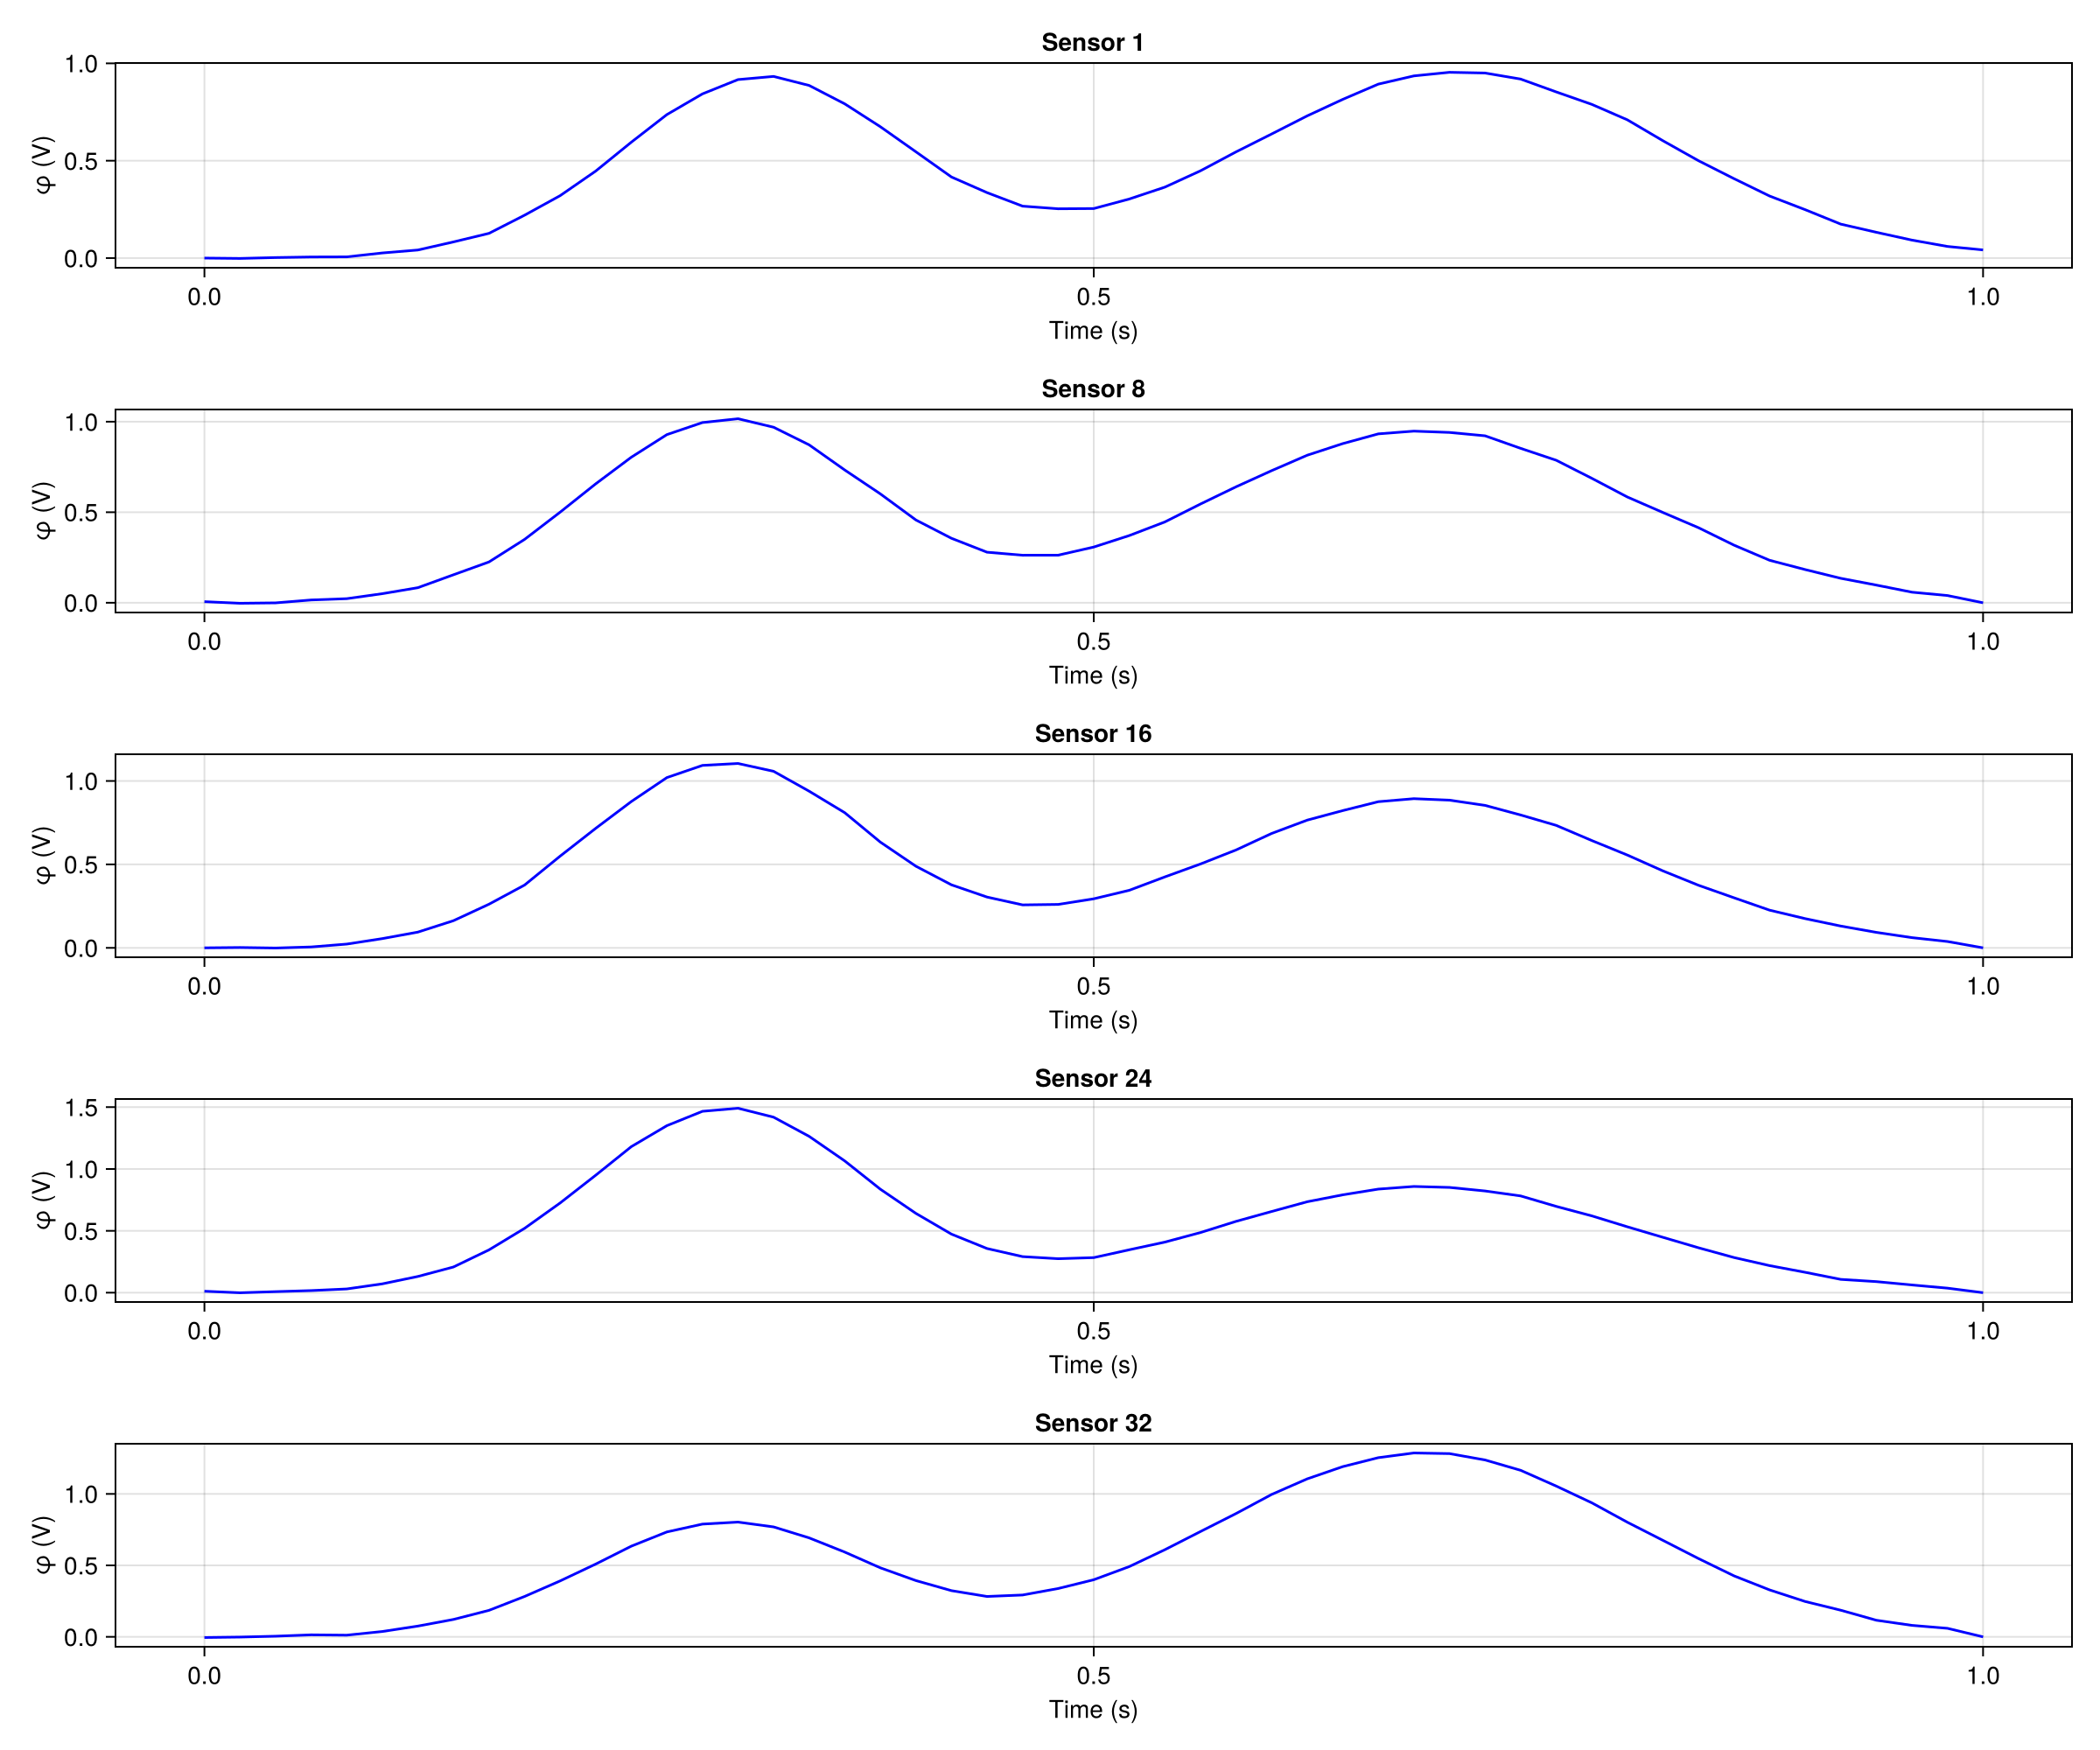

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Временные ряды отображены для датчиков: [1, 8, 16, 24, 32]


In [10]:
using CairoMakie

# Визуализация временных рядов для отдельных датчиков (robust)
num_time_steps = size(measured_phi, 2)
selected_sensors = [1, max(1,div(num_sensors,4)), max(1,div(num_sensors,2)), max(1,3*div(num_sensors,4)), num_sensors]
time_vec = range(0, duration, length=num_time_steps)

fig_ts = Figure(resolution=(1200, 1000), title="Временные ряды измеренных данных")
for (i, sensor_idx) in enumerate(selected_sensors)
    ax = Axis(fig_ts[i, 1]; xlabel="Time (s)", ylabel="φ (V)", title="Sensor $sensor_idx")
    lines!(ax, time_vec, measured_phi[sensor_idx, :]; color=:blue)
end

display(fig_ts)
println("✓ Временные ряды отображены для датчиков: ", selected_sensors)


### 3.3 Пространственное распределение потенциала

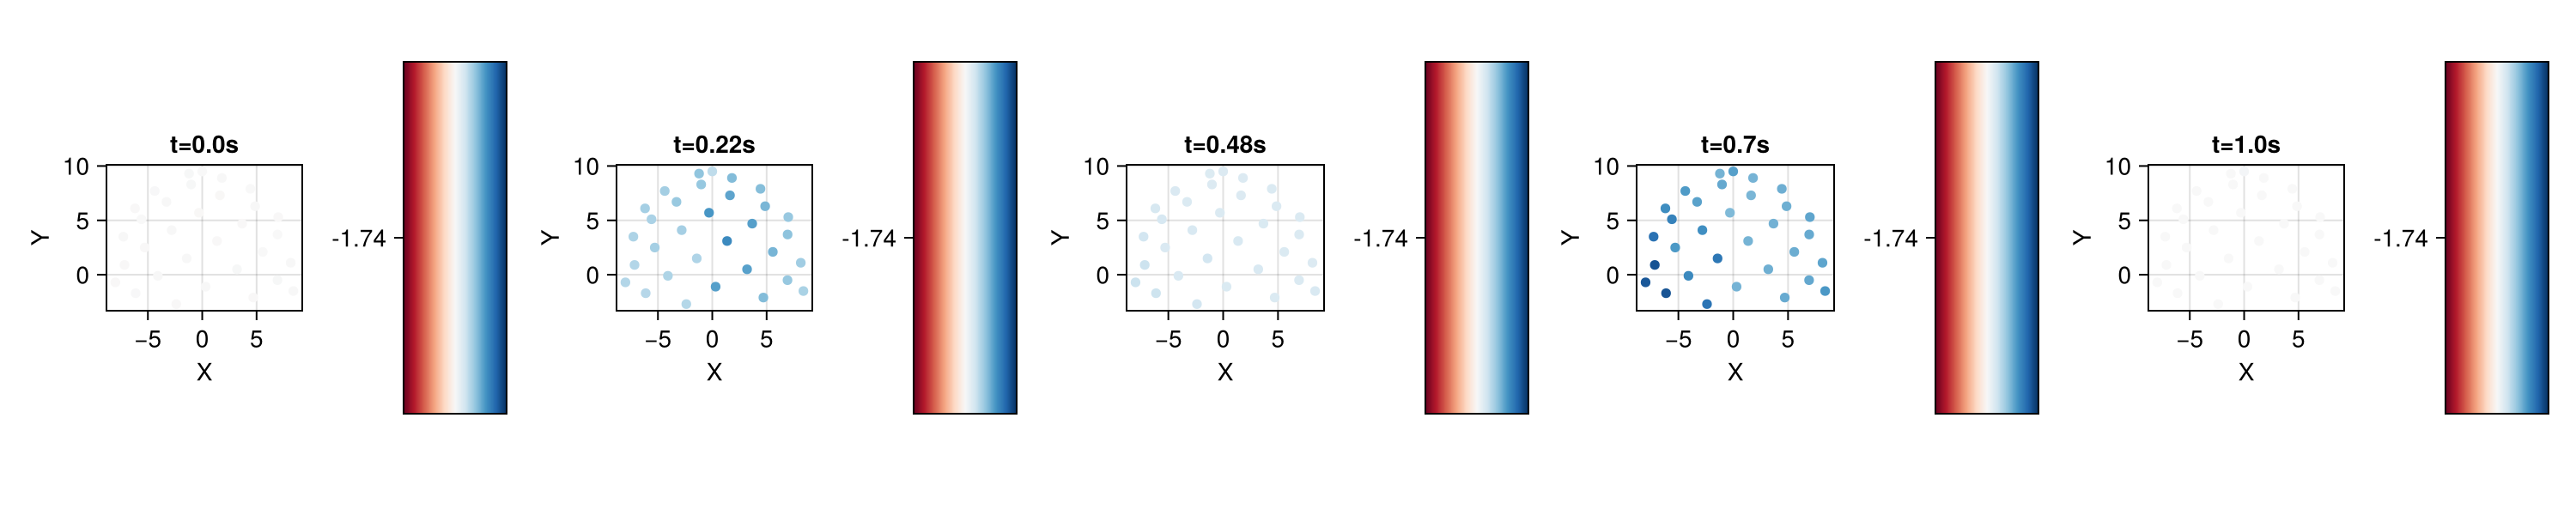

✓ Пространственное распределение отображено для временных срезов: 

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


[1, 12, 25, 36, 51]


In [ ]:
using CairoMakie

# Визуализация пространственного распределения потенциала (robust)
num_time_steps = size(measured_phi, 2)
time_vec = range(0, duration, length=num_time_steps)
time_indices = [1, max(1,div(num_time_steps,4)), max(1,div(num_time_steps,2)), max(1,3*div(num_time_steps,4)), num_time_steps]
time_indices = unique(clamp.(time_indices, 1, num_time_steps))

vmax = maximum(abs.(measured_phi))

n = length(time_indices)
fig_spatial = Figure(resolution=(1500, 300))
for (i, t_idx) in enumerate(time_indices)
    t_idx = Int(clamp(t_idx, 1, num_time_steps))
    ax = Axis(fig_spatial[1, 2*i - 1]; title="t=$(round(time_vec[t_idx], digits=3))s", xlabel="X", ylabel="Y", aspect=DataAspect())
    sc = scatter!(ax, sensor_positions[:, 1], sensor_positions[:, 2];
        color=measured_phi[:, t_idx], colormap=:RdBu, markersize=8, colorrange=(-vmax, vmax))

    # Manual colorbar: draw a vertical heatmap in the adjacent column and label ticks
    cbax = Axis(fig_spatial[1, 2*i]; ylabel = "", width = 60)
    cvals = reshape(collect(range(-vmax, vmax, length=256)), 256, 1)
    heatmap!(cbax, cvals; colormap = :RdBu, colorrange = (-vmax, vmax))
    # Map y ticks to color values
    tick_idxs = [1, 64, 128, 192, 256]
    tick_vals = round.(collect(range(-vmax, vmax, length=length(tick_idxs))), digits=3)
    cbax.yticks = (tick_idxs, string.(tick_vals))
    cbax.xticks = ([], [])
end

display(fig_spatial)
println("✓ Пространственное распределение отображено для временных срезов: ", time_indices)


## 4. Конвертация данных из Python в Julia

In [12]:
"""
    convert_py_points_to_julia(py_points) -> Vector{Vector{Float64}}

Конвертирует Python список измеренных точек в Julia формат.

Формат точки: [x, y, z, t, phi_measured]
"""
function convert_py_points_to_julia(py_points)
    n_points = length(py_points)
    julia_points = Vector{Vector{Float64}}(undef, n_points)
    
    for i in 1:n_points
        py_point = py_points[i-1]  # Python индексация с 0
        julia_points[i] = [
            pyconvert(Float64, py_point[0]),  # x
            pyconvert(Float64, py_point[1]),  # y
            pyconvert(Float64, py_point[2]),  # z
            pyconvert(Float64, py_point[3]),  # t
            pyconvert(Float64, py_point[4])   # phi_measured
        ]
    end
    
    return julia_points
end

# Конвертируем данные
measured_points = convert_py_points_to_julia(py_measured_points)

println("✓ Конвертировано в Julia: $(length(measured_points)) точек")
println("Пример первой точки: ", measured_points[1])

✓ Конвертировано в Julia: 1600 точек
Пример первой точки: [0.0, 9.5, 0.0, 0.0, 0.012270820490054494]


## 5. Настройка конфигураций для обучения

In [13]:
# Конфигурация нейронной сети
nn_config = NeuralNetworkConfig(;
    input_dim = 4,                    # [x, y, z, t]
    hidden_layers = [32, 32, 32, 32],     # Архитектура скрытых слоёв
    output_dim = 8,                   # [φ, Ax, Ay, Az, ρ, jx, jy, jz]
    activation = :tanh,               # Функция активации
    use_gpu = true                    # Использовать GPU если доступен
)

println("✓ Нейросеть: $(nn_config.hidden_layers) -> $(nn_config.output_dim)")

✓ Нейросеть: [32, 32, 32, 32] -> 8


In [14]:
# Конфигурация оптимизации
opt_config = OptimizationConfig(;
    optimizer = :adam,                # Оптимизатор Adam
    learning_rate = 0.01,            # Скорость обучения
    max_iterations = 200,            # Количество итераций
    log_frequency = 50,               # Частота логирования
    use_tensorboard = true,           # Логирование в TensorBoard
    log_directory = "logs/eeg_julia_exp"
)

println("✓ Оптимизация: $(opt_config.optimizer), lr=$(opt_config.learning_rate), iter=$(opt_config.max_iterations)")

✓ Оптимизация: adam, lr=0.01, iter=200


In [15]:
# Конфигурация функции потерь с адаптивным балансом (improvement-based scheduler)
loss_config = LossFunctionConfig(;
    lambda_pde = 1.0,                 # Вес PDE потерь
    lambda_bc = 1.0,                  # Вес граничных условий
    lambda_data_init = 10.0,           # Начальный вес данных
    # using improvement-based scheduler
    lambda_min = 1.0,               # Минимум lambda_data (global)
    lambda_max = nothing,             # Максимум lambda_data (global)
    lambda_schedule_type = :improvement,
    lambda_schedule = Dict{String,Any}("window_size" => 10, "increase_factor" => 1.25, "decrease_factor" => 0.99, "patience" => 5, "min_improvement" => 1e-8, "lambda_min" => 1.0, "lambda_max" => 1e5),
    measured_points = measured_points # Измеренные точки
)

println("✓ Loss scheduler: $(loss_config.lambda_schedule_type), lambda_init=$(loss_config.lambda_data_init), λ∈[$(loss_config.lambda_min), $(loss_config.lambda_max)]")

✓ Loss scheduler: improvement, lambda_init=10.0, λ∈[1.0, nothing]


In [16]:
# Конфигурация PML (Perfectly Matched Layer)
pml_config = PMLConfig(;
    enabled = true,                   # Включить PML
    pml_thickness_ratio = 0.1,        # Толщина PML (10% от домена)
    reflection_coefficient = 0.001,   # Коэффициент отражения
    gamma_max = nothing,              # Автоматический расчёт
    alpha_max = nothing               # Автоматический расчёт
)

println("✓ PML: включён, толщина=$(pml_config.pml_thickness_ratio*100)%")

✓ PML: включён, толщина=10.0%


In [17]:
# Конфигурация домена
# Используем уже сконвертированные размеры rx, ry, rz из предыдущей ячейки

domain_config = Dict{Any, Any}(
    "x_range" => [-13.0, 13.0],
    "y_range" => [-13.0, 13.0],
    "z_range" => [-13.0, 13.0],
    "t_range" => [0.0, 1],  # Соответствует продолжительности 0.5 сек
    "num_points" => 1024
)

println("✓ Домен: X∈$(domain_config["x_range"]), Y∈$(domain_config["y_range"]), Z∈$(domain_config["z_range"])")

✓ Домен: X∈[-13.0, 13.0], Y∈[-13.0, 13.0], Z∈[-13.0, 13.0]


In [18]:
const_config = PhysicalConstants(; c=1.0, ε=1.0, μ=1.0,ε₀=1.0, μ₀=1.0)

PhysicalConstants(1.0, 1.0, 1.0, 1.0, 1.0)

## 6. Запуск обучения

In [19]:
run(`bash -c "source $(@__DIR__)/../.venv/bin/activate && tensorboard --logdir=logs --port=6006"`, wait=false)

Process(`bash -c 'source /home/sasha/inverse-npde/examples/../.venv/bin/activate && tensorboard --logdir=logs --port=6006'`, ProcessRunning)

In [40]:
println("🚀 Запуск решения обратной задачи ЭЭГ...")
println("=" ^ 60)

# Запускаем эксперимент
results = run_eeg_inverse_problem(;
    measured_points = measured_points,
    nn_config = nn_config,
    opt_config = opt_config,
    loss_config = loss_config,
    domain_config = domain_config,
    pml_config = pml_config
)

println("=" ^ 60)
println("✅ Обучение завершено!")

🚀 Запуск решения обратной задачи ЭЭГ...
🚀 Запуск эксперимента обратной задачи ЭЭГ...
✅ PML включён (толщина: 10.0%, R: 0.001)
   γ_max: auto, α_max: auto
✓ Данные нормированы, фактор: 0.510748
✓ Размерность выхода нейросети: 8 (PML: включён)
✓ Используем нормированные измеренные точки


┌ Warning: Lux layers are stateless and hence don't participate in device transfers. Apply this function on the parameters and states generated using `LuxCore.setup`.
└ @ LuxCoreMLDataDevicesExt /home/sasha/.julia/packages/LuxCore/qsnGJ/ext/LuxCoreMLDataDevicesExt.jl:10


✓ Настройка создана


┌ Info: Constructing PhysicsInformedNN (GPU-first). Ensure chain and params are on desired device
└ @ InverseNpde.Optimization /home/sasha/inverse-npde/src/neural_pde_solver/Optimization.jl:232


✓ Discretization создан (адаптивный планировщик: improvement)
✓ PDE система дискретизирована
🔄 Начинаем оптимизацию...


0.5%┣▏                                         ┫ 1/200 [02:41<Inf:Inf, InfGs/it]
1.0%┣┫ 2/200 [02:44<09:00:52, 164s/it, Loss: 393476.719, PDE: 393807.188, Data: 1.509, λ: 9.9]
2.0%┣┫ 4/200 [02:46<03:00:31, 55s/it, Loss: 114528.000, PDE: 111646.805, Data: 1.366, λ: 9.7]
3.0%┣┫ 6/200 [02:47<01:48:16, 33s/it, Loss: 52584.145, PDE: 56065.332, Data: 1.274, λ: 9.5]
4.0%┣┫ 8/200 [02:49<01:17:27, 24s/it, Loss: 31995.443, PDE: 30789.512, Data: 1.199, λ: 9.3]
4.5%┣┫ 9/200 [02:51<01:07:55, 21s/it, Loss: 26962.234, PDE: 25617.355, Data: 1.172, λ: 9.2]
5.5%┣┫ 11/200 [02:52<54:16, 17s/it, Loss: 17251.137, PDE: 21148.871, Data: 1.146, λ: 9.0]
6.5%┣┫ 13/200 [02:54<45:09, 14s/it, Loss: 13935.146, PDE: 13457.019, Data: 1.135, λ: 8.9]
7.0%┣┫ 14/200 [02:55<41:42, 13s/it, Loss: 12018.194, PDE: 11192.989, Data: 1.128, λ: 8.8]
7.5%┣┫ 15/200 [02:56<38:44, 13s/it, Loss: 11831.953, PDE: 10830.944, Data: 1.120, λ: 8.7]
8.5%┣┫ 17/200 [02:58<33:54, 11s/it, Loss: 8066.265, PDE: 8489.037, Data: 1.103, λ: 8.5]
9.5%┣┫

✓ Оптимизация завершена


┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl /home/sasha/.julia/packages/LuxLib/utJLG/src/impl/matmul.jl:190


📊 Расчет значений φ по равномерной сетке для визуализации...
  ⏰ Обработка временного шага t = 0.0
  ⏰ Обработка временного шага t = 0.245
  ⏰ Обработка временного шага t = 0.49
  ⏰ Обработка временного шага t = 0.735
  ⏰ Обработка временного шага t = 0.98
✓ Расчет равномерной сетки завершен
✅ Обучение завершено!


## 7. Анализ результатов

In [41]:
# Извлекаем результаты
analysis = results.results

println("📊 Метрики на датчиках:")
println("   MSE: $(round(analysis["overall_mse"], digits=6))")
println("   MAE: $(round(analysis["overall_mae"], digits=6))")
println("   Max Error: $(round(analysis["overall_max_error"], digits=6))")
println("   Финальный λ_data: $(round(results.final_lambda_data, digits=4))")

📊 Метрики на датчиках:
   MSE: 0.236204
   MAE: 0.376423
   Max Error: 1.569639
   Финальный λ_data: 40.1999


### 7.2 Визуализация предсказанных данных

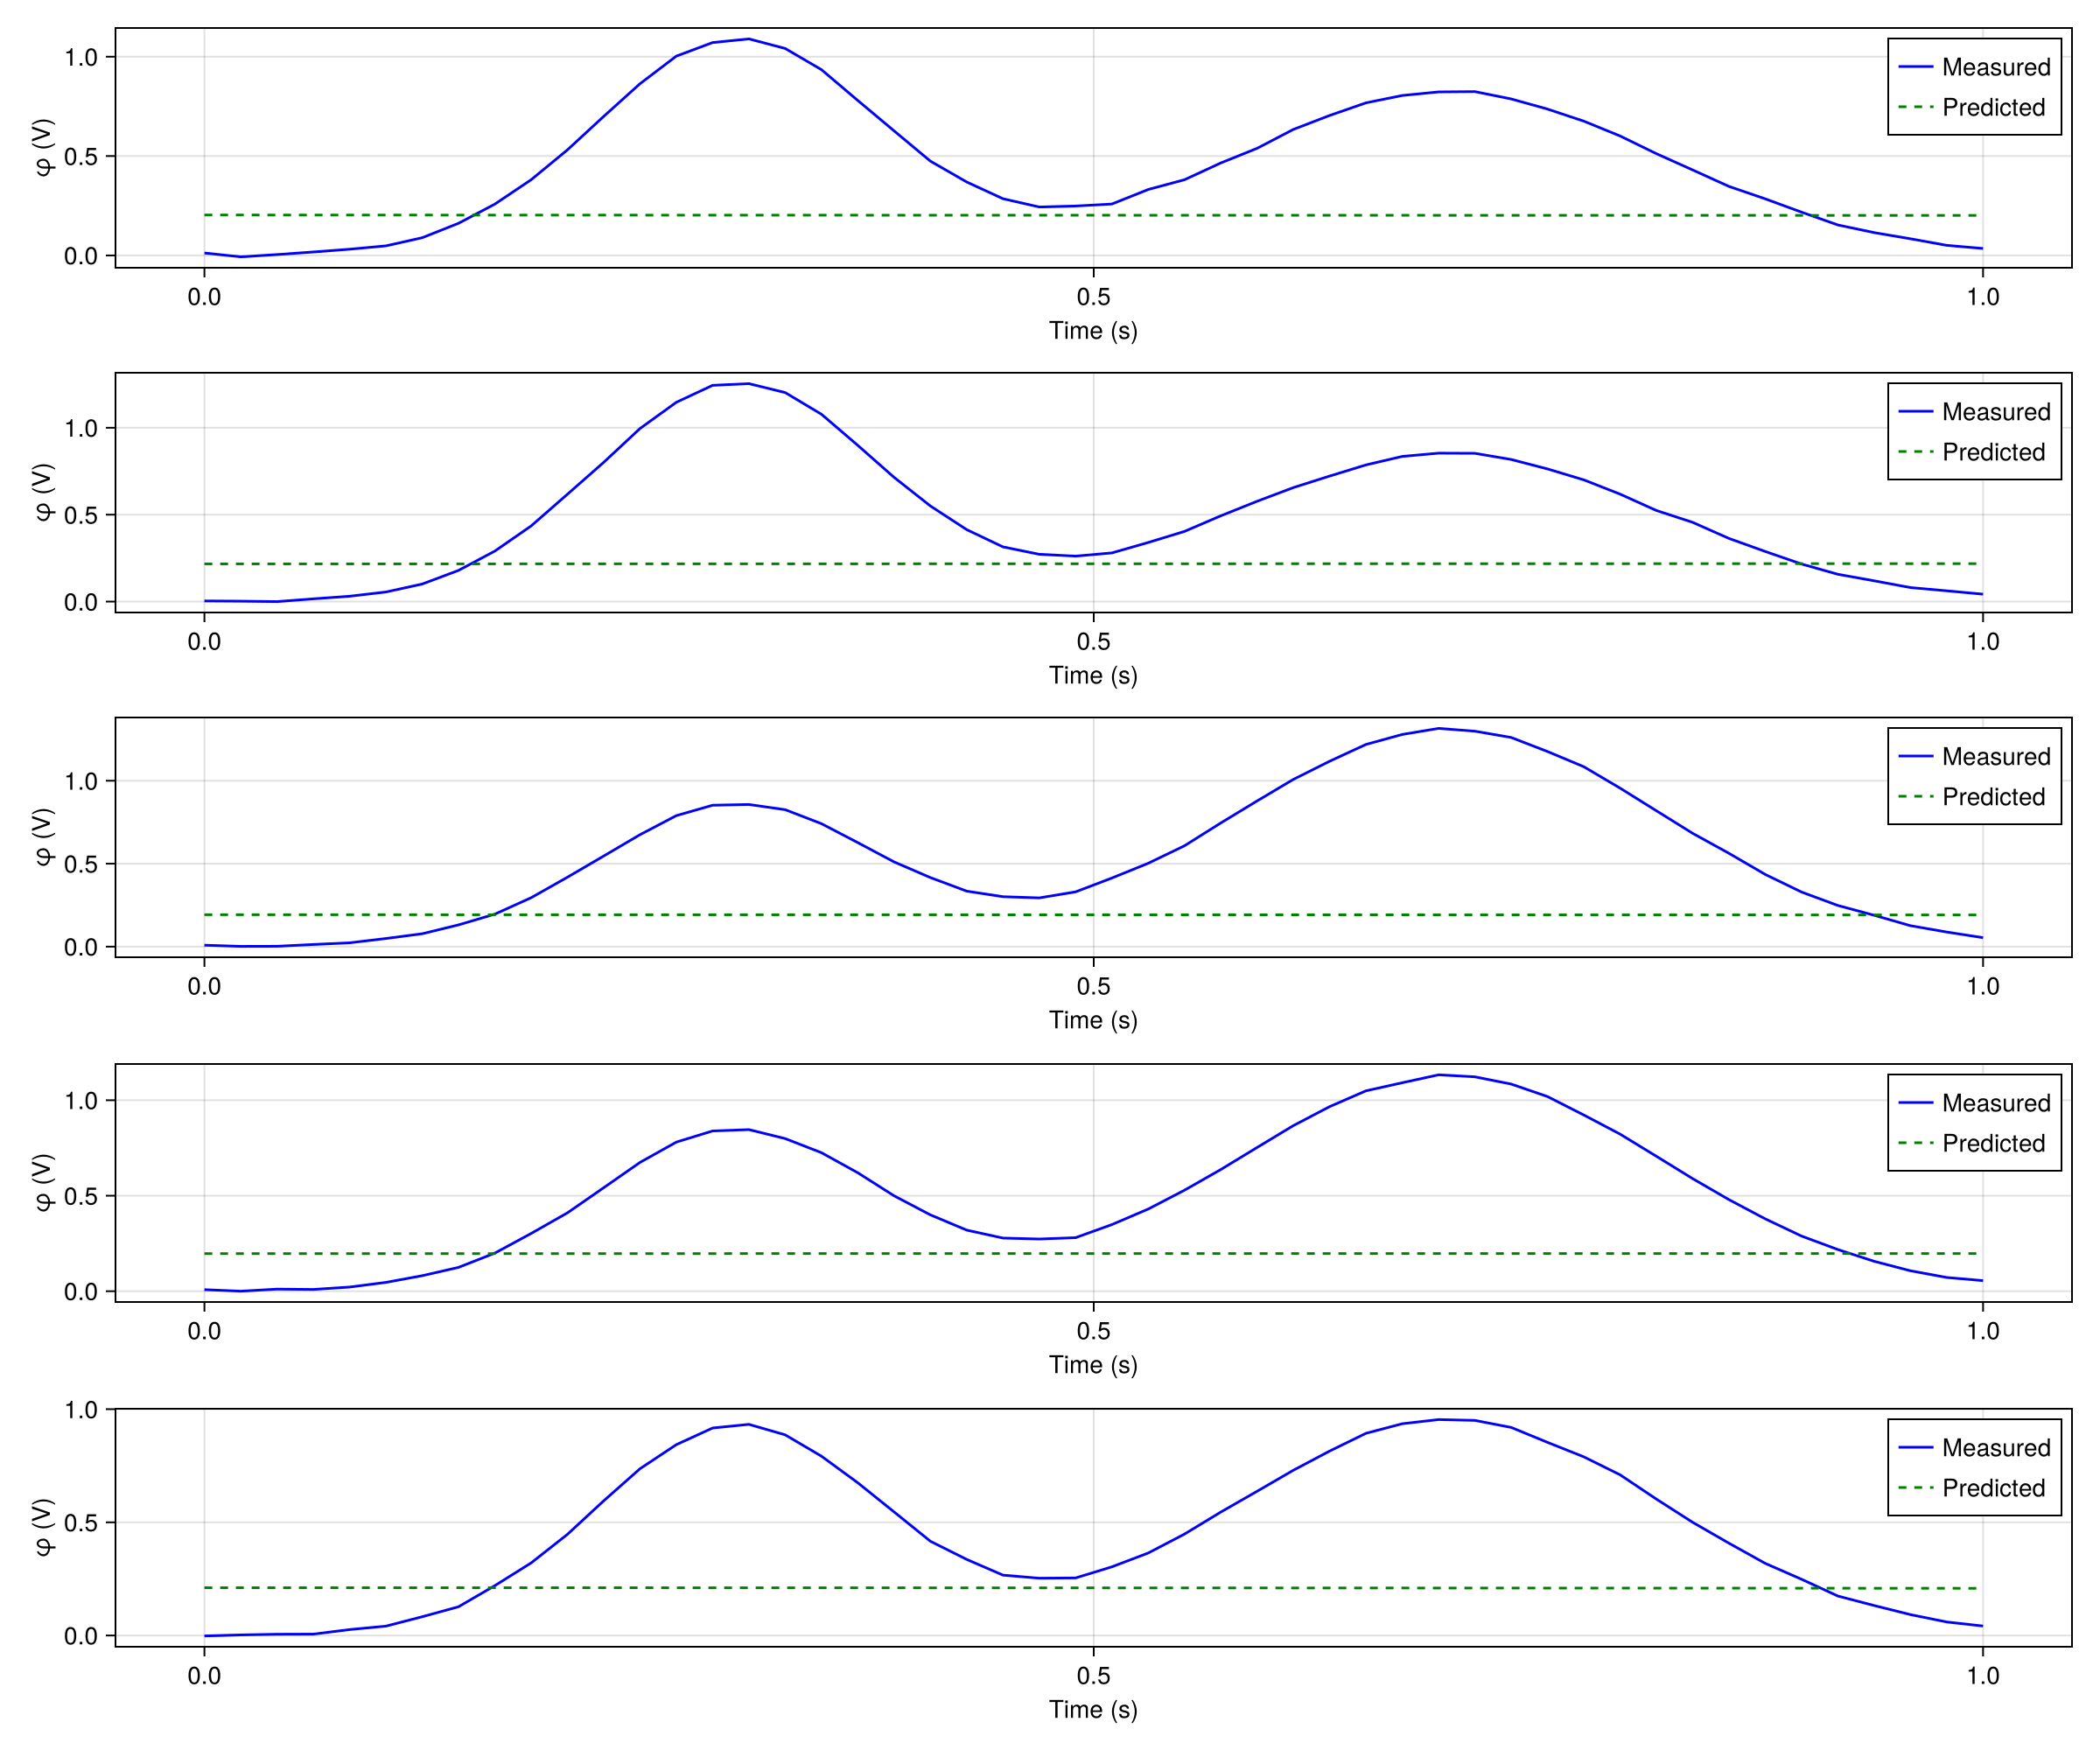

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Предсказанные временные ряды отображены (overlay)


In [54]:
using CairoMakie

# Предсказанные временные ряды и overlay с измеренными (robust)
# извлекаем данные из analysis (должны быть после run)
if !haskey(analysis, "sensor_data")
    error("analysis[\"sensor_data\"] missing")
end
sensor_data = analysis["sensor_data"]
x_coords = sensor_data["x_coords"]; y_coords = sensor_data["y_coords"]; z_coords = sensor_data["z_coords"]; t_coords = sensor_data["t_coords"]
measured_vec = sensor_data["measured_phi"]
predicted_vec = haskey(sensor_data, "predicted_phi") ? sensor_data["predicted_phi"] : nothing

# Reshape и подготовка (robust inference of sizes)
L = length(measured_vec)

function infer_dims(L, sensor_positions, analysis)
    candidates = Int[]
    if @isdefined sensor_positions
        push!(candidates, size(sensor_positions,1))
    end
    if haskey(analysis, "num_sensors")
        push!(candidates, Int(analysis["num_sensors"]))
    end
    if haskey(analysis, "num_time_steps")
        push!(candidates, Int(analysis["num_time_steps"]))
    end

    # add divisors of L (reasonable range)
    for i in 1:floor(Int, sqrt(L))
        if L % i == 0
            push!(candidates, i)
            push!(candidates, L ÷ i)
        end
    end
    candidates = unique(filter(x -> x>0 && x<=L, candidates))

    # prefer sensor_positions match
    if @isdefined sensor_positions
        sp = size(sensor_positions,1)
        if sp in candidates && L % sp == 0
            return sp, Int(L/sp)
        end
    end

    # prefer known num_time_steps
    if haskey(analysis, "num_time_steps")
        nt = Int(analysis["num_time_steps"])
        if nt>0 && L % nt == 0
            return Int(L/nt), nt
        end
    end

    # pick a reasonable candidate (sensors <=512)
    sortc = sort(candidates)
    for ns in sortc
        nt = L ÷ ns
        if ns>1 && nt>1 && ns<=512
            return ns, nt
        end
    end

    # fallback: treat as sensors × 1
    return L, 1
end

num_sensors, num_time_steps = infer_dims(L, sensor_positions, analysis)
if num_sensors * num_time_steps != L
    error("Incompatible measured vector length=$(L) with inferred num_sensors=$(num_sensors) and num_time_steps=$(num_time_steps); please check analysis or sensor_positions")
end

# если предсказания ещё не вычислены, делаем пакетный вызов
if predicted_vec === nothing
    println("predicted_phi not present in analysis — computing batch predictions...")
    all_data = hcat(results.measured_points...)
    coords_batch = Float64.(all_data[1:4, :])
    params = results.params
    pred_all = results.phi(coords_batch, params)
    phi_pred_norm = Float64.(vec(pred_all[1, :]) |> cpud)
    predicted_vec = phi_pred_norm .* (haskey(analysis, "norm_factor") ? analysis["norm_factor"] : 1.0)
    sensor_data["predicted_phi"] = predicted_vec
end

measured_mat = reshape(Float64.(measured_vec), num_sensors, num_time_steps)
predicted_mat = reshape(Float64.(predicted_vec), num_sensors, num_time_steps)

selected_sensors = [1, max(1,div(num_sensors,4)), max(1,div(num_sensors,2)), max(1,3*div(num_sensors,4)), num_sensors]
time_vec = range(0, duration, length=num_time_steps)

fig_pred_ts = Figure(resolution=(1200,1000), title="Временные ряды: измеренное (синее) vs предсказанное (зелёное)")
for (i, sensor_idx) in enumerate(selected_sensors)
    ax = Axis(fig_pred_ts[i,1]; xlabel="Time (s)", ylabel="φ (V)")
    lines!(ax, time_vec, measured_mat[sensor_idx, :]; color=:blue, label="Measured")
    lines!(ax, time_vec, predicted_mat[sensor_idx, :]; color=:green, linestyle=:dash, label="Predicted")
    axislegend(ax)
end

display(fig_pred_ts)
println("✓ Предсказанные временные ряды отображены (overlay)")


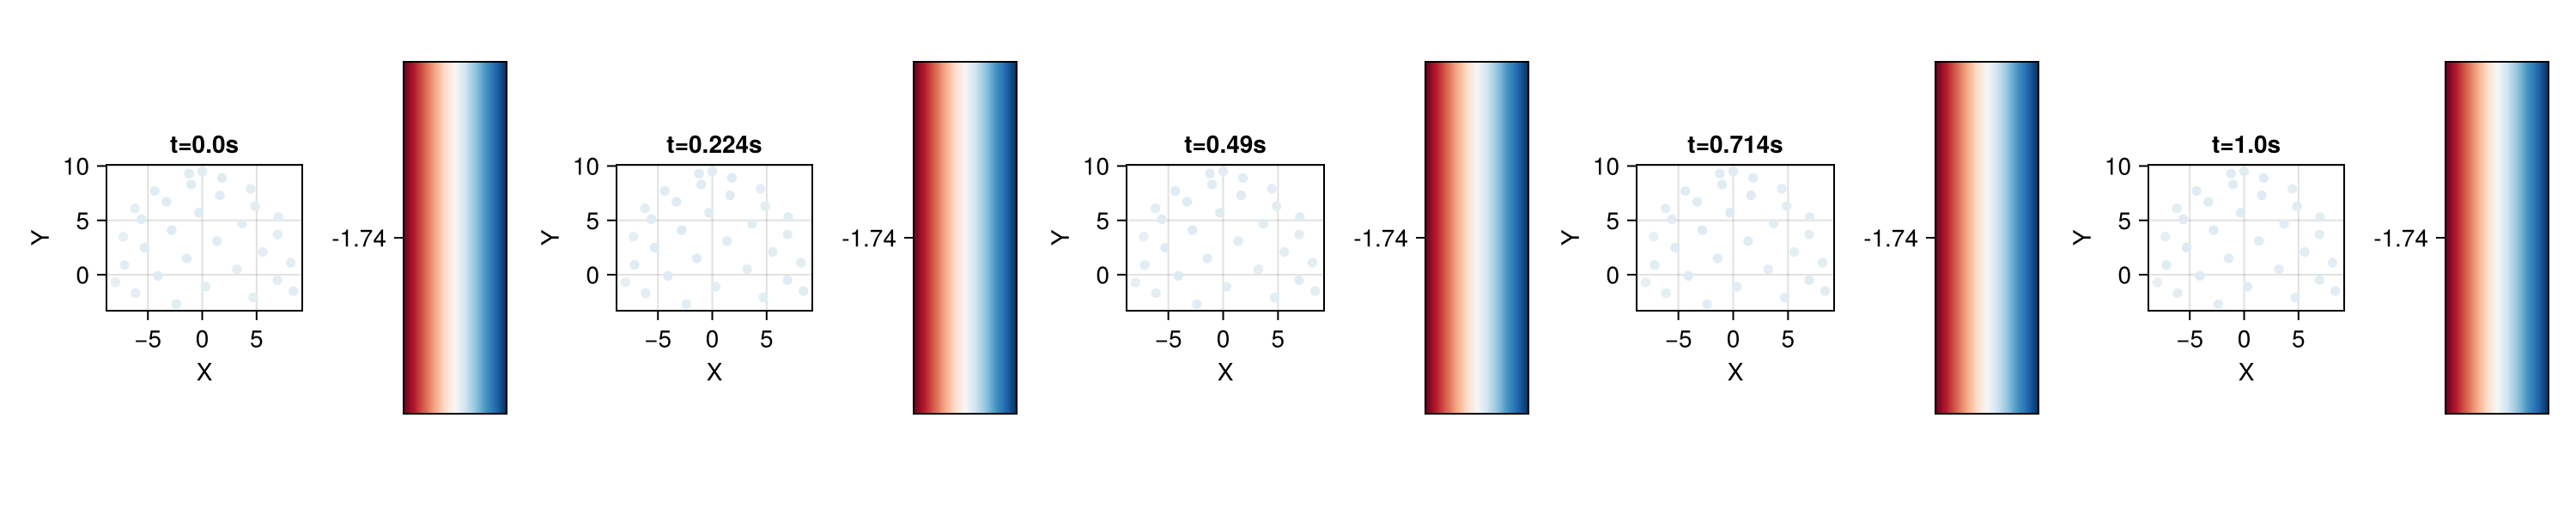

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Пространственное распределение предсказаний отображено


In [57]:
using CairoMakie

# Пространственное распределение предсказанных данных (comparison)
num_time_steps = size(predicted_mat, 2)
time_vec = range(0, duration, length=num_time_steps)
time_indices = [1, max(1,div(num_time_steps,4)), max(1,div(num_time_steps,2)), max(1,3*div(num_time_steps,4)), num_time_steps]
time_indices = unique(clamp.(time_indices, 1, num_time_steps))

vmax_all = maximum(abs.(vcat(measured_mat[:], predicted_mat[:])))

n = length(time_indices)
fig_pred_spatial = Figure(resolution=(1500, 300))
for (i, t_idx) in enumerate(time_indices)
    t_idx = Int(clamp(t_idx, 1, num_time_steps))
    ax = Axis(fig_pred_spatial[1, 2*i - 1]; title="t=$(round(time_vec[t_idx], digits=3))s", xlabel="X", ylabel="Y", aspect=DataAspect())
    sc = scatter!(ax, sensor_positions[:, 1], sensor_positions[:, 2];
        color=predicted_mat[:, t_idx], colormap=:RdBu, markersize=8, colorrange=(-vmax_all, vmax_all))

    # Manual colorbar axis
    cbax = Axis(fig_pred_spatial[1, 2*i]; ylabel = "", width = 60)
    cvals = reshape(collect(range(-vmax_all, vmax_all, length=256)), 256, 1)
    heatmap!(cbax, cvals; colormap = :RdBu, colorrange = (-vmax_all, vmax_all))
    tick_idxs = [1, 64, 128, 192, 256]
    tick_vals = round.(collect(range(-vmax_all, vmax_all, length=length(tick_idxs))), digits=3)
    cbax.yticks = (tick_idxs, string.(tick_vals))
    cbax.xticks = ([], [])
end

display(fig_pred_spatial)
println("✓ Пространственное распределение предсказаний отображено")


In [58]:
# Метрики по временным шагам
time_metrics = analysis["time_step_metrics"]
time_steps = analysis["time_steps"]

println("📈 Метрики по времени:")
for (i, t) in enumerate(time_steps[1:min(5, length(time_steps))])
    m = time_metrics[t]
    println("   t=$(round(t, digits=3)): MSE=$(round(m["mse"], digits=6)), MAE=$(round(m["mae"], digits=6))")
end

📈 Метрики по времени:
   t=0.0: MSE=0.042222, MAE=0.204817
   t=0.02: MSE=0.04192, MAE=0.204052
   t=0.041: MSE=0.040977, MAE=0.20172
   t=0.061: MSE=0.037938, MAE=0.193937
   t=0.082: MSE=0.0329, MAE=0.18032


## 10. Сравнение измеренных и предсказанных значений

Overall RMSE=0.486008  MAE=0.376423


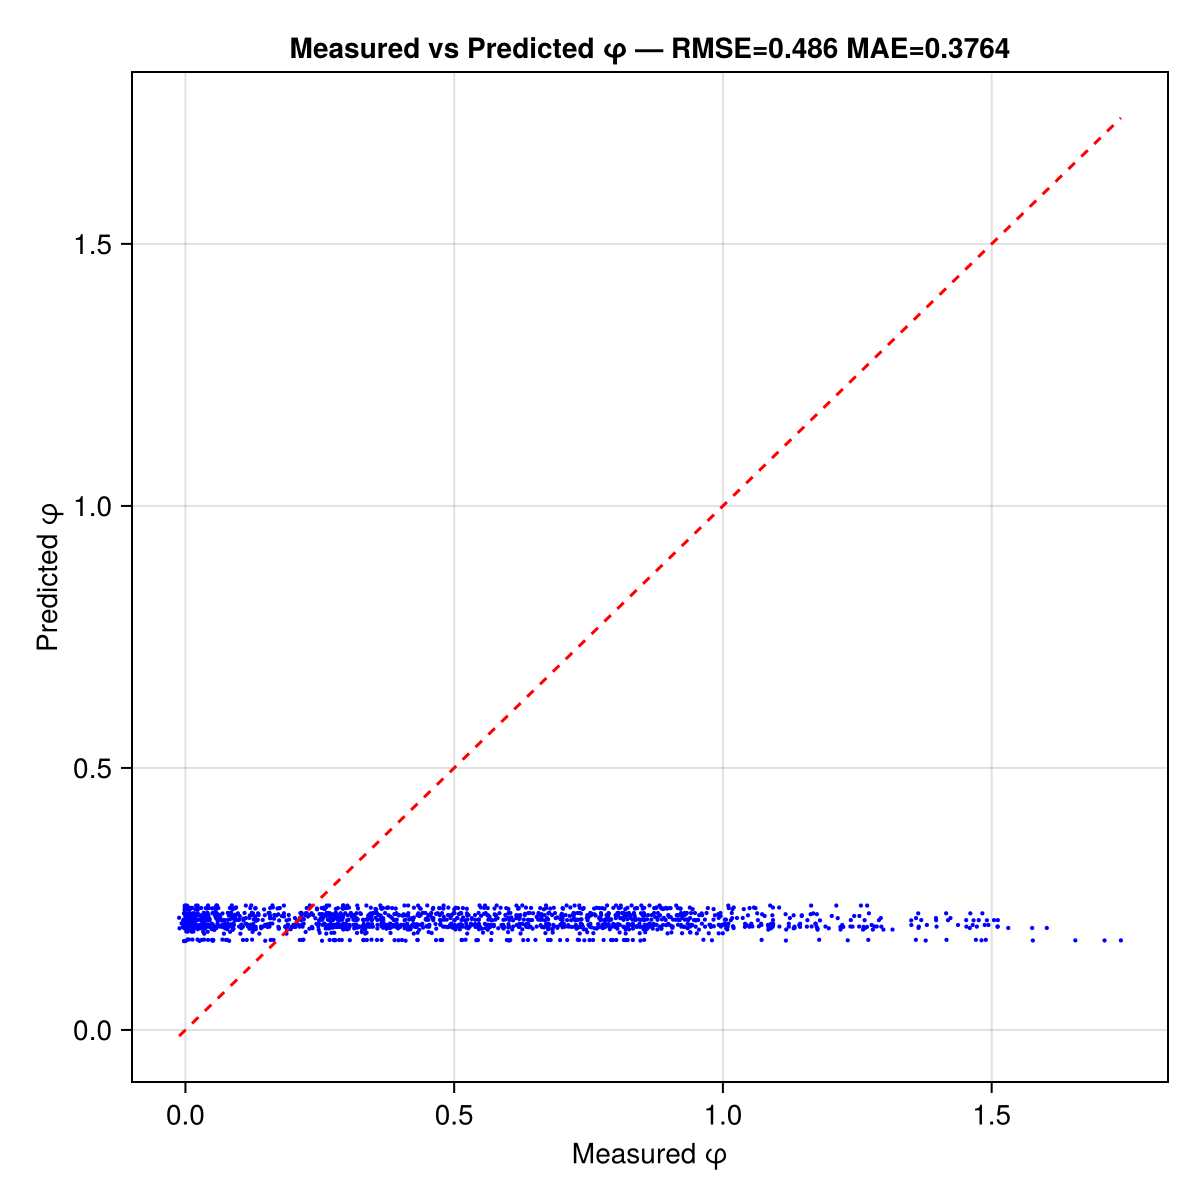

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


CairoMakie.Screen{IMAGE}


In [70]:
using Statistics, CairoMakie

# Сравнение измеренных и предсказанных значений (scatter, metrics)
sensor_data = analysis["sensor_data"]
x_coords = sensor_data["x_coords"]; y_coords = sensor_data["y_coords"]; z_coords = sensor_data["z_coords"]; t_coords = sensor_data["t_coords"]
measured_vec = sensor_data["measured_phi"]
predicted_vec = sensor_data["predicted_phi"]

# Robust inference of sizes for reshape
L = length(measured_vec)

function infer_dims(L, sensor_positions, analysis)
    candidates = Int[]
    if @isdefined sensor_positions
        push!(candidates, size(sensor_positions,1))
    end
    if haskey(analysis, "num_sensors")
        push!(candidates, Int(analysis["num_sensors"]))
    end
    if haskey(analysis, "num_time_steps")
        push!(candidates, Int(analysis["num_time_steps"]))
    end

    for i in 1:floor(Int, sqrt(L))
        if L % i == 0
            push!(candidates, i)
            push!(candidates, L ÷ i)
        end
    end
    candidates = unique(filter(x -> x>0 && x<=L, candidates))

    if @isdefined sensor_positions
        sp = size(sensor_positions,1)
        if sp in candidates && L % sp == 0
            return sp, Int(L/sp)
        end
    end

    if haskey(analysis, "num_time_steps")
        nt = Int(analysis["num_time_steps"])
        if nt>0 && L % nt == 0
            return Int(L/nt), nt
        end
    end

    sortc = sort(candidates)
    for ns in sortc
        nt = L ÷ ns
        if ns>1 && nt>1 && ns<=512
            return ns, nt
        end
    end

    return L, 1
end

num_sensors, num_time_steps = infer_dims(L, sensor_positions, analysis)
if num_sensors * num_time_steps != L
    error("Incompatible measured vector length=$(L) with inferred num_sensors=$(num_sensors) and num_time_steps=$(num_time_steps); please check analysis or sensor_positions")
end

# Reshape to matrices (sensors × time)
measured_mat = reshape(Float64.(measured_vec), num_sensors, num_time_steps)
predicted_mat = reshape(Float64.(predicted_vec), num_sensors, num_time_steps)

# Overall metrics
all_meas = vec(measured_mat); all_pred = vec(predicted_mat)
overall_rmse = sqrt(mean((all_meas .- all_pred).^2))
overall_mae = mean(abs.(all_meas .- all_pred))
println("Overall RMSE=", round(overall_rmse, digits=6), "  MAE=", round(overall_mae, digits=6))

mn = min(minimum(all_meas), minimum(all_pred))
mx = max(maximum(all_meas), maximum(all_pred))

fig_scatter = Figure(resolution=(600,600))
ax = Axis(fig_scatter[1,1]; xlabel="Measured φ", ylabel="Predicted φ", title="Measured vs Predicted φ — RMSE=$(round(overall_rmse,digits=4)) MAE=$(round(overall_mae,digits=4))")
scatter!(ax, all_meas, all_pred; markersize=3, color=:blue, transparency=true)
lines!(ax, [mn, mx], [mn, mx]; color=:red, linestyle=:dash)

display(fig_scatter)


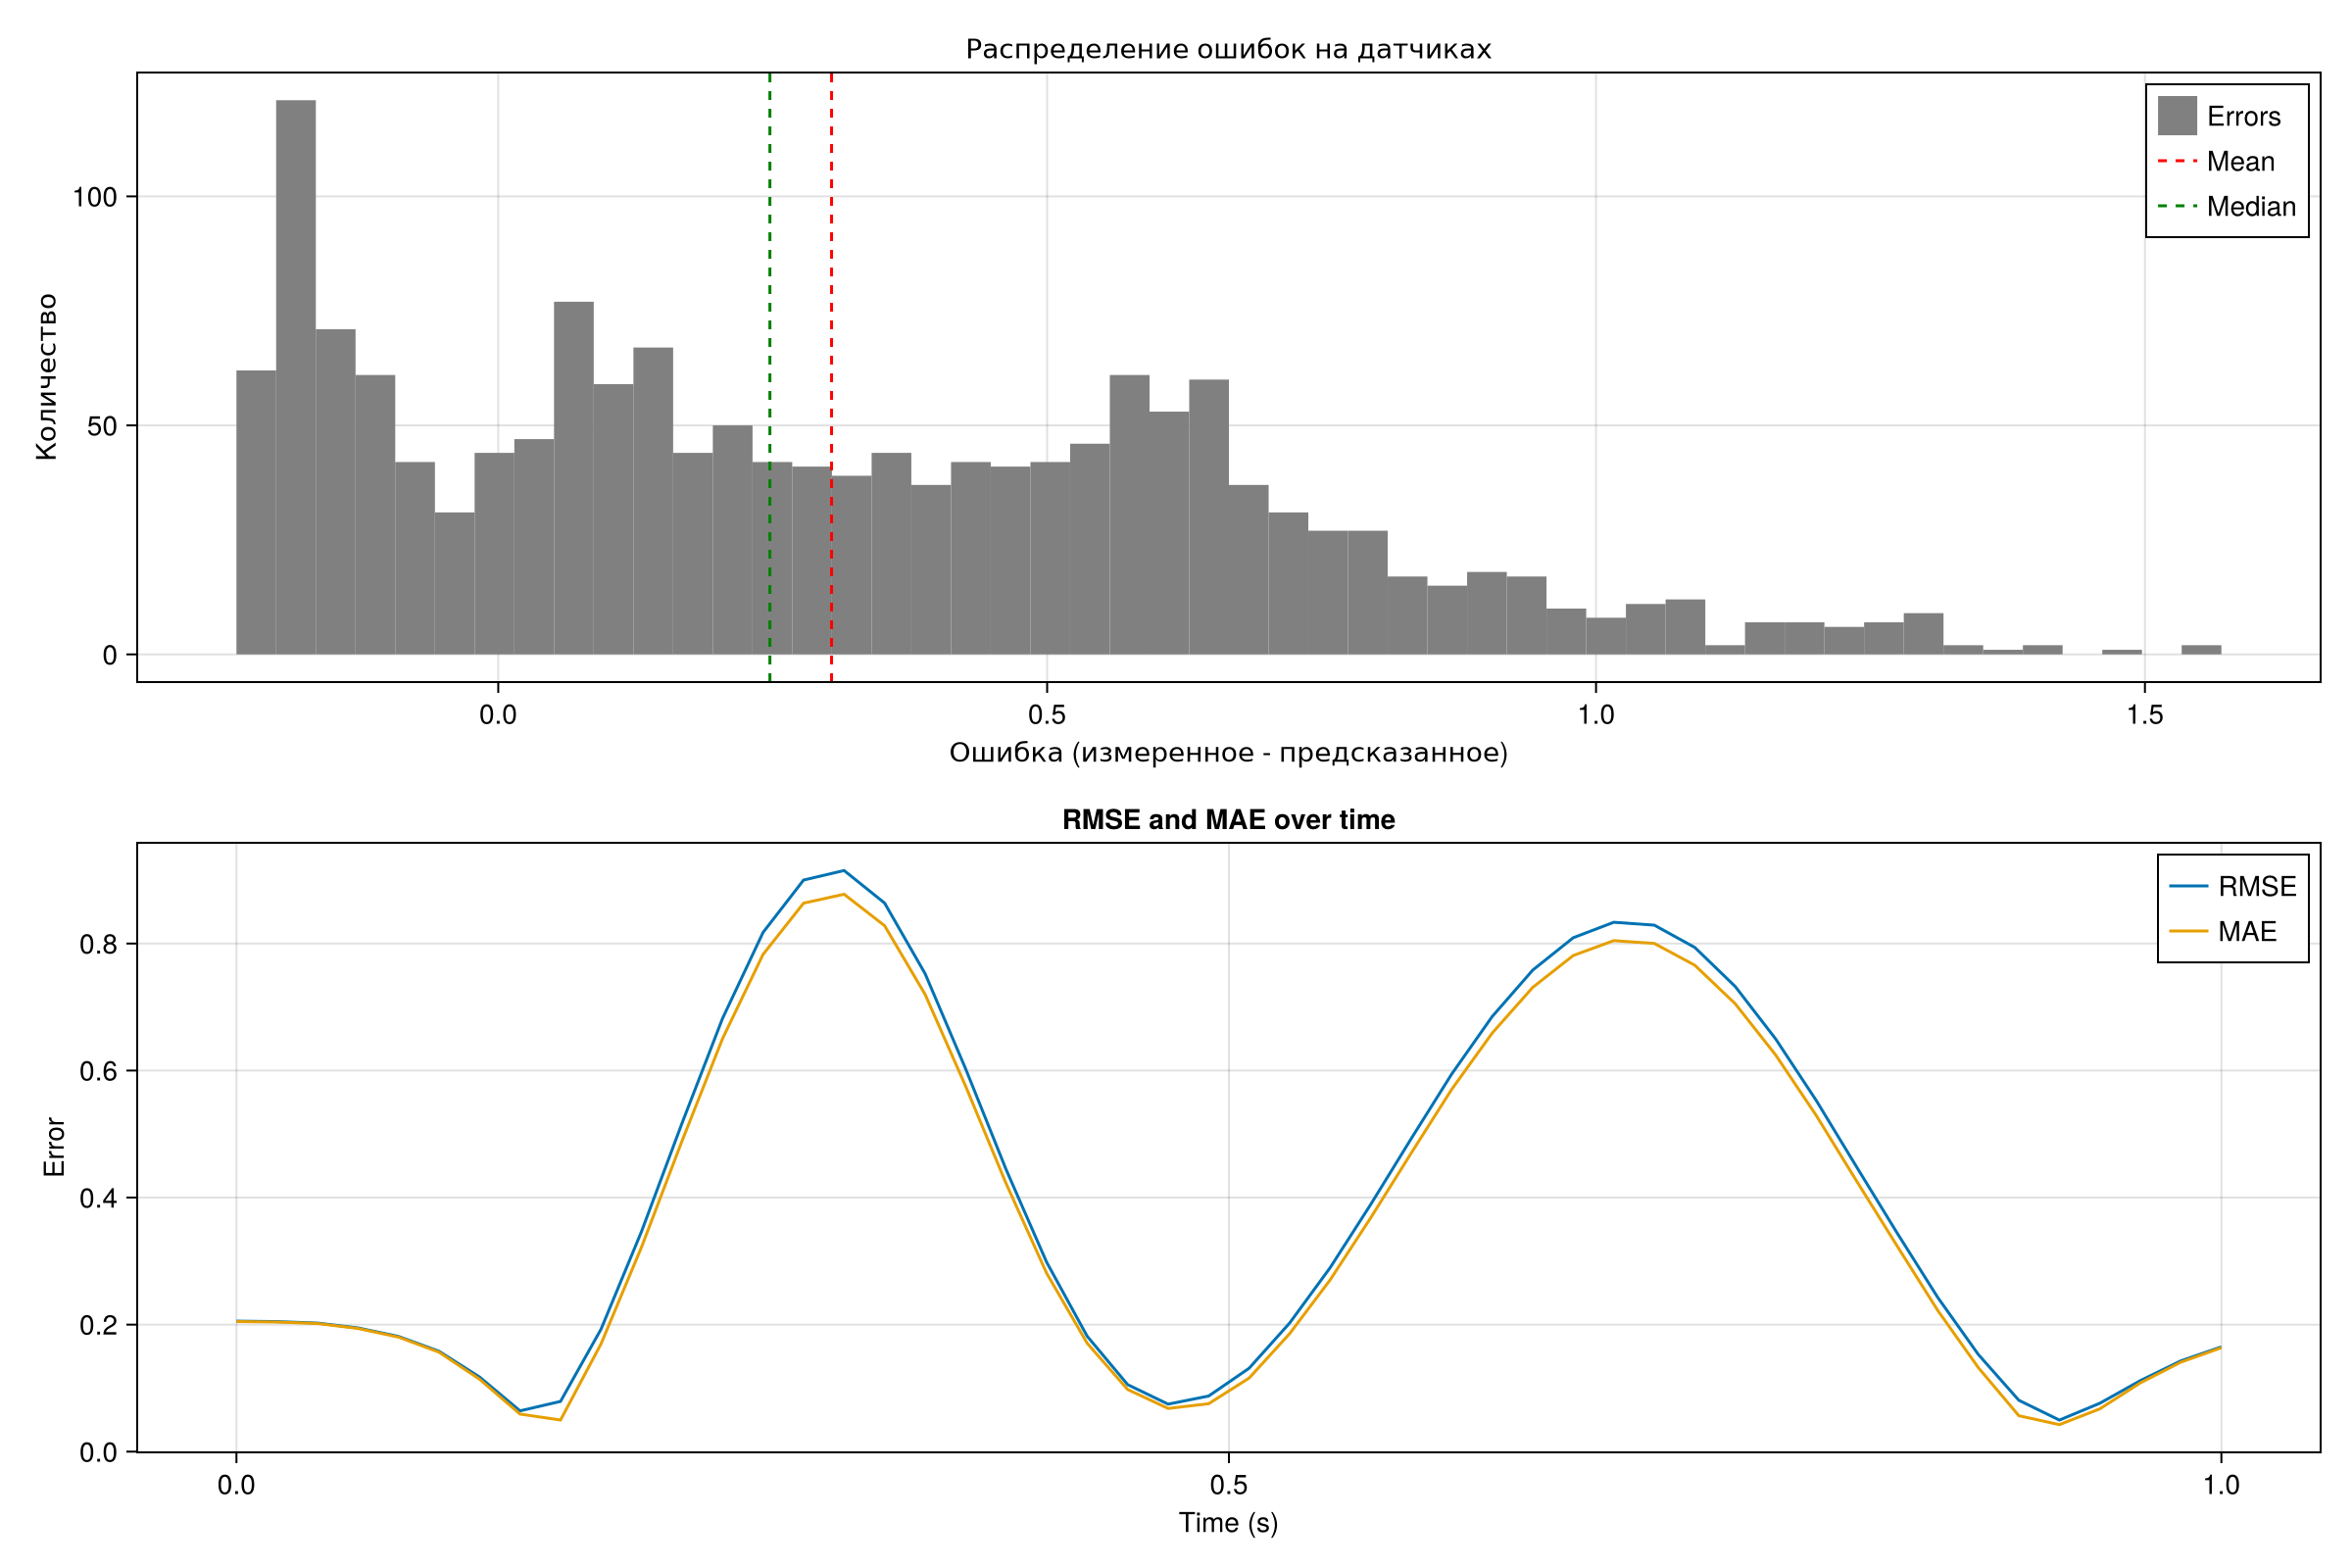

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


CairoMakie.Screen{IMAGE}


In [71]:
using Statistics, CairoMakie

# Гистограмма ошибок и RMSE/MAE по времени
errors = vec(measured_mat) .- vec(predicted_mat)

fig = Figure(resolution=(1200,800))
ax1 = Axis(fig[1,1]; title="Распределение ошибок на датчиках", xlabel="Ошибка (измеренное - предсказанное)", ylabel="Количество")
hist!(ax1, errors; bins=50, color=:gray, label="Errors")
vmean = mean(errors); vmed = median(errors)
vlines!(ax1, [vmean]; color=:red, linestyle=:dash, label="Mean")
vlines!(ax1, [vmed]; color=:green, linestyle=:dash, label="Median")
axislegend(ax1)

rmse_t = [sqrt(mean((measured_mat[:, i] .- predicted_mat[:, i]).^2)) for i in 1:size(measured_mat, 2)]
mae_t = [mean(abs.(measured_mat[:, i] .- predicted_mat[:, i])) for i in 1:size(measured_mat, 2)]
time_vec = range(0, duration, length=size(measured_mat, 2))
ax2 = Axis(fig[2,1]; title="RMSE and MAE over time", xlabel="Time (s)", ylabel="Error")
lines!(ax2, time_vec, rmse_t; label="RMSE")
lines!(ax2, time_vec, mae_t; label="MAE")
axislegend(ax2)

display(fig)
